In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,classification_report,roc_auc_score,f1_score,precision_recall_fscore_support
from model_statistics_func import plot_confusion_matrix,get_feature_importance

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold


import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline

import statsmodels.api as st
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression as LR
#import sklearn.cross_validation as skcv
import sklearn.model_selection
from sklearn.model_selection import cross_validate as skcv

#from pandas_ml import ConfusionMatrix
from sklearn.model_selection import StratifiedKFold

from IPython.display import display, HTML

from sklearn.model_selection import train_test_split


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize


# ordinal classification approach - Baseline
#### based on this paper https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf
https://github.com/sarvothaman/ordinal-classification/blob/master/ordinal-classification.ipynb

1. Create "dummy" fields, one for each quality we are considering leving out the last quality (8)
2. Set this dummy field to 1, if the current quality is greater than the quality which the field represents
    Eg: Row with quality 6 has the following fields (gt_4 =1, gt_5=1, gt_6=0, gt_7=0)
3. Build one regular logistic model for each dummy field. Each of these models will be able to predict the probability of current quality  being greater than a quality which the model is built for
4. Use following formula to calculate probability of each quality

# step 0

In [2]:
#load dataset
raw_dataset=pd.read_pickle('dataset.pkl')
def convert_numeric_score_to_cat(score_code):
    score_dict={0:'TRUE',0.2:'mostly_true',0.5:'half_true',0.7:'misleading',0.8:'mostly_untrue',1:'untrue'}
    return score_dict.get(score_code)

raw_dataset['score']=raw_dataset['score_code'].apply(lambda x: convert_numeric_score_to_cat(x))
raw_dataset.drop('score_code',axis=1,inplace=True)
#remove missleading
raw_dataset=raw_dataset[raw_dataset.score!='misleading']

# step 1 + 2 

In [3]:
fields=['untrue','mostly untrue','half true','mostly true','TRUE']

In [4]:
%%capture
raw_dataset["gt_TRUE_class"]=0
raw_dataset.ix[(raw_dataset.score!='TRUE'),'gt_TRUE_class']=1


raw_dataset["gt_mostly_true_class"]=0
raw_dataset.ix[(raw_dataset.score=='half_true')|(raw_dataset.score=='mostly_untrue')|(raw_dataset.score=='untrue'),'gt_mostly_true_class']=1


raw_dataset["gt_half_true_class"]=0
raw_dataset.ix[(raw_dataset.score=='mostly_untrue')|(raw_dataset.score=='untrue'),'gt_half_true_class']=1


raw_dataset["gt_mostly_untrue_class"]=0
raw_dataset.ix[(raw_dataset.score=='untrue'),'gt_mostly_untrue_class']=1


# step 3

In [5]:
X = raw_dataset[raw_dataset.columns[:-5].to_list() + ["gt_TRUE_class","gt_mostly_true_class","gt_half_true_class","gt_mostly_untrue_class"]]
y  = raw_dataset['score']
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)


In [6]:
#train kfolds
n_splits=5
n_repeats=10

In [188]:
X

,word_count,distinct_word_count,avg_chars_per_word,TTR,Flesch_Kincaid,h_hayedia_count,syllabls_count,uncertainty_words_usage,first_names_usage,last_names_usage,...,IMPERATIVE,qoutes_count,hashtag_count,positive_semantic,negative_semantic,objective_semantic,gt_TRUE_class,gt_mostly_true_class,gt_half_true_class,gt_mostly_untrue_class
0,18,18,4.388889,1.000000,62.758571,0.040000,34,0,4,3,...,0,0,0,0.980871,0.012410,0.006719,1,1,1,1
1,57,52,4.052632,0.912281,23.543135,0.072289,121,0,3,6,...,0,0,0,0.615095,0.309213,0.075692,1,1,0,0
2,31,26,3.838710,0.838710,21.447143,0.088889,62,0,3,1,...,0,0,0,0.054728,0.894451,0.050821,1,1,0,0
3,32,32,4.000000,1.000000,19.895000,0.106383,64,0,4,5,...,0,0,0,0.766881,0.188297,0.044822,1,1,1,1
4,19,19,4.842105,1.000000,-0.076818,0.156250,48,0,0,2,...,0,0,0,0.994935,0.003275,0.001790,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,28,28,4.857143,1.000000,-18.638750,0.088889,73,0,2,2,...,0,0,0,0.079561,0.883846,0.036593,0,0,0,0
466,47,45,4.468085,0.957447,-10.013443,0.068493,119,0,3,9,...,0,0,0,0.858649,0.103828,0.037523,0,0,0,0
467,35,34,5.114286,0.971429,-10.357500,0.127273,91,0,1,4,...,0,0,0,0.991906,0.005280,0.002814,0,0,0,0
468,11,11,4.909091,1.000000,-27.366364,0.187500,29,0,0,2,...,0,0,0,0.166972,0.787908,0.045120,0,0,0,0


In [7]:
dst=X.to_numpy()
dst.shape

(470, 10880)

In [8]:
label=y.to_numpy()

In [14]:
skf=RepeatedStratifiedKFold(n_splits=n_splits,n_repeats=n_repeats)
skf.get_n_splits(dst,label)

##trained model sum varibales
precision_avg=0
recall_score_avg=0
f1_score_avg=0
roc_auc_avg=0

for train_index, test_index in skf.split(dst,label):
    X_train, X_test = dst[train_index], dst[test_index]
    y_train, y_test = label[train_index], label[test_index]
    X_train= pd.DataFrame(data=X_train, index=[train_index], columns=list(X.columns))
    X_test= pd.DataFrame(data=X_test, index=[test_index], columns=list(X.columns))

    precision,recall,f_score,roc_auc=run_model(X_train,X_test,y_train,y_test)
    precision_avg=precision_avg+precision
    recall_score_avg=recall_score_avg+recall
    f1_score_avg=f1_score_avg+f_score
    roc_auc_avg=roc_auc_avg+roc_auc

print('results:')
print('precision: ', precision_avg/(n_splits*n_repeats))
print('recall: ',recall_score_avg/(n_splits*n_repeats))
print('fscore: ' ,f1_score_avg/(n_splits*n_repeats))
print('roc-auc: ',roc_auc_avg/(n_splits*n_repeats))

results:
precision:  0.25189828873130243
recall:  0.3389361702127659
fscore:  0.2822086274865515
roc-auc:  0.5245462507315996


In [9]:
def run_model(X_train,X_test,y_train,y_test):
    # Model for score > TRUE
    logreg = LogisticRegression(class_weight='balanced')

    logreg_TRUE_result=logreg.fit(X_train[X_train.columns.difference(["gt_TRUE_class","gt_mostly_true_class","gt_half_true_class",
                                                                     "gt_mostly_untrue_class"])],X_train['gt_TRUE_class'])

    TRUE_model=logreg_TRUE_result
    X_test["TRUE_predictions"]=logreg_TRUE_result.predict_proba(X_test[X_test.columns.difference
                                                                         (["gt_TRUE_class","gt_mostly_true_class","gt_half_true_class",
                                                                           "gt_mostly_untrue_class"])])[:,1]

    X_test["TRUE"]=1 - X_test["TRUE_predictions"]


    # Model for score> mostly true
    logreg_mostly_true_result=logreg.fit(X_train[X_train.columns.difference(["gt_TRUE_class","gt_mostly_true_class","gt_half_true_class",
                                                                     "gt_mostly_untrue_class"])],X_train['gt_mostly_true_class'])


    mostly_true_model=logreg_mostly_true_result
    X_test["mostly_true_predictions"]=logreg_mostly_true_result.predict_proba(X_test[X_test.columns.difference(["gt_TRUE_class","gt_mostly_true_class",
                                                                                                          "gt_half_true_class",
                                                                                                          "gt_mostly_untrue_class",
                                                                                                          "TRUE","TRUE_predictions"])])[:,1]
    X_test["mostly_true"]= X_test["TRUE_predictions"] - X_test["mostly_true_predictions"]



    # Model for score> half true
    logreg_half_true_result=logreg.fit(X_train[X_train.columns.difference(["gt_TRUE_class","gt_mostly_true_class","gt_half_true_class",
                                                                     "gt_mostly_untrue_class"])],X_train['gt_half_true_class'])


    half_true_model=logreg_half_true_result
    X_test["half_true_predictions"]=logreg_half_true_result.predict_proba(X_test[X_test.columns.difference([ "gt_TRUE_class",
                                                                                                      "gt_mostly_true_class",
                                                                                                      "gt_half_true_class",
                                                                                                      "gt_mostly_untrue_class",
                                                                                                      "TRUE","TRUE_predictions",
                                                                                                      "mostly_true",
                                                                                                      "mostly_true_predictions"])])[:,1]
    X_test["half_true"]= X_test["mostly_true_predictions"] - X_test["half_true_predictions"]


    # Model for score> mostly untrue

    logreg_mostly_untrue_result=logreg.fit(X_train[X_train.columns.difference(["gt_TRUE_class","gt_mostly_true_class","gt_half_true_class",
                                                                     "gt_mostly_untrue_class"])],X_train['gt_mostly_untrue_class'])

    mostly_untrue_model=logreg_mostly_untrue_result

    X_test["mostly_untrue_predictions"]=logreg_mostly_untrue_result.predict_proba(X_test[X_test.columns.difference([ "gt_TRUE_class",
                                                                                                              "gt_mostly_true_class",
                                                                                                              "gt_half_true_class",
                                                                                                              "gt_mostly_untrue_class",
                                                                                                              "TRUE","TRUE_predictions","mostly_true",
                                                                                                              "mostly_true_predictions","half_true",
                                                                                                              "half_true_predictions"])])[:,1]
    X_test["mostly_untrue"]= X_test["half_true_predictions"] - X_test["mostly_untrue_predictions"]
    X_test["untrue"]= X_test["half_true_predictions"]


    X_test["assigned_class_prob"]=X_test[["TRUE","mostly_true","half_true","mostly_untrue","untrue"]].idxmax(axis=1)
    #X_test["predicted_quality"]=pd.to_numeric(X_test["assigned_class_prob"].str[-1])

    y_pred=X_test["assigned_class_prob"]
    y_score_numpy=X_test[["TRUE","mostly_true","half_true","mostly_untrue","untrue"]].to_numpy()
    y_score=get_yscore(y_score_numpy)
    return model_results(y_test,y_pred,y_score)

In [10]:
def get_yscore(y_score_numpy):

    #min max scaler to avoid negative values
    scaler = MinMaxScaler()
    scaler.fit(y_score_numpy)
    y_score_numpy=scaler.transform(y_score_numpy)

    #normalize to sum up to 1 
    y_score = normalize(y_score_numpy, axis=1, norm='l1')
    return y_score

In [13]:
def model_results(y_test,y_pred,y_score):
    #print precision
    precision=precision_score(y_test,y_pred,average='weighted')
    #print recall
    recall=recall_score(y_test, y_pred,average='weighted')
    #print fscore
    fscore=f1_score(y_test, y_pred,average='weighted')
    #print roc-auc
    rocauc=roc_auc_score(y_test,y_score,multi_class='ovr')
    return precision,recall,fscore,rocauc

In [133]:
print('accuracy %s' % accuracy_score(X_test["assigned_class_prob"], y_test))
print(classification_report(y_test, X_test["assigned_class_prob"]))

accuracy 0.3617021276595745
               precision    recall  f1-score   support

         TRUE       0.30      0.38      0.33        29
    half_true       0.33      0.14      0.20        14
  mostly_true       0.09      0.07      0.08        15
mostly_untrue       0.00      0.00      0.00        26
       untrue       0.43      0.65      0.51        57

     accuracy                           0.36       141
    macro avg       0.23      0.25      0.22       141
 weighted avg       0.28      0.36      0.30       141



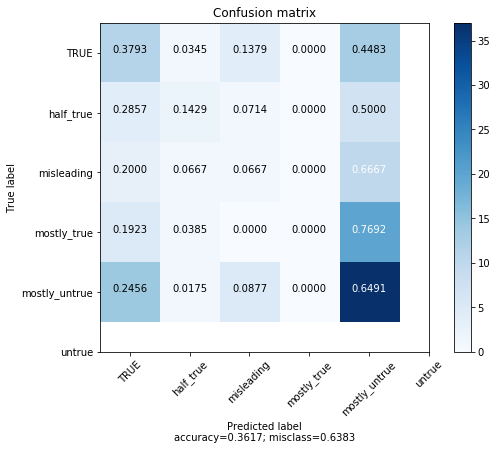

In [134]:
cm=confusion_matrix(y_test, X_test["assigned_class_prob"])
plot_confusion_matrix(cm,target_names=['TRUE','half_true','misleading','mostly_true','mostly_untrue','untrue'])

In [135]:
precision_recall_fscore_support(y_test, X_test["assigned_class_prob"],average='weighted')

(0.27583903519340053, 0.3617021276595745, 0.30434169849063464, None)

In [211]:
f1_score(y_test, X_test["assigned_class_prob"],average='weighted')

0.25

In [137]:
recall_score(y_test, X_test["assigned_class_prob"],average='weighted')

0.3617021276595745

In [138]:
roc_auc_score(y_test,y_score,multi_class='ovr')

0.5490746484436756